In [2]:
import pandas as pd


In [4]:
df = pd.read_csv('/content/safety_data.csv')

In [10]:
# keep just the columns we need
side_effects = ['headache', 'ab.pain','dyspepsia', 'upper.resp.infect', 'coad']
columns_to_keep = ['id', 'trx', 'age'] + side_effects
df = df[columns_to_keep]


In [11]:
df.head()


,id,trx,age,headache,ab.pain,dyspepsia,upper.resp.infect,coad
0,1,Drug,62,0.0,0.0,0.0,0.0,0.0
1,1,Drug,62,0.0,0.0,0.0,0.0,0.0
2,1,Drug,62,0.0,0.0,0.0,0.0,0.0
3,1,Drug,62,0.0,0.0,0.0,0.0,0.0
4,1,Drug,62,0.0,0.0,0.0,0.0,0.0


In [12]:
# capture if any side effect occurred at any time during the trial.
df_grouped = df.groupby('id').agg({
    'trx': 'first',
    'age': 'first',
    'headache': 'max',       # max tells us if they ever had the symptom
    'ab.pain': 'max',
    'dyspepsia': 'max',
    'upper.resp.infect': 'max',
    'coad': 'max'
}).reset_index()

In [7]:
df.head()

,week,headache,ab.pain,dyspepsia,upper.resp.infect,coad,trx,age,sex,race,...,pr,qrs,rr,uncorr.qt,dbp,hr,sbp,id,nausea,diarrhea
0,0,0.0,0.0,0.0,0.0,0.0,Drug,62,male,Caucasian,...,156.0,64.0,571.400024,340.0,80.0,88.0,128.0,1,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,Drug,62,male,Caucasian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.0
2,12,0.0,0.0,0.0,0.0,0.0,Drug,62,male,Caucasian,...,156.0,76.0,722.799988,368.0,78.0,88.0,120.0,1,0.0,0.0
3,16,0.0,0.0,0.0,0.0,0.0,Drug,62,male,Caucasian,...,160.0,72.0,689.599976,360.0,72.0,88.0,126.0,1,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,Drug,62,male,Caucasian,...,160.0,72.0,666.599976,352.0,82.0,86.0,120.0,1,0.0,0.0


In [8]:
df_grouped.head()


,id,trx,age,headache,ab.pain,dyspepsia,upper.resp.infect,coad
0,1,Drug,62,0.0,0.0,3.0,1.0,0.0
1,2,Drug,69,0.0,0.0,0.0,0.0,0.0
2,3,Drug,67,0.0,0.0,1.0,0.0,0.0
3,4,Drug,65,0.0,0.0,0.0,1.0,1.0
4,5,Placebo,73,0.0,0.0,0.0,0.0,0.0


In [13]:
df_grouped['adverse_effects'] = df_grouped[side_effects].sum(axis =1).apply(lambda x: 1 if x > 0 else 0)
df_grouped['num_effects'] = df_grouped[side_effects].sum(axis=1)

In [12]:
df_grouped.head()

,id,trx,age,headache,ab.pain,dyspepsia,upper.resp.infect,coad,adverse_effects,num_effects
0,1,Drug,62,0.0,0.0,3.0,1.0,0.0,1,4.0
1,2,Drug,69,0.0,0.0,0.0,0.0,0.0,0,0.0
2,3,Drug,67,0.0,0.0,1.0,0.0,0.0,1,1.0
3,4,Drug,65,0.0,0.0,0.0,1.0,1.0,1,2.0
4,5,Placebo,73,0.0,0.0,0.0,0.0,0.0,0,0.0


### Question 1
###### Is the proportion of patients who had adverse effects significantly higher in the Drug group compared to the Placebo group?


In [13]:
from statsmodels.stats.proportion import proportions_ztest

In [15]:
# count number of patients with adverse effects
adverse_counts = df_grouped.groupby('trx')['adverse_effects'].sum()
sample_sizes =df_grouped['trx'].value_counts()

#Extract values for the test
count = [adverse_counts['Drug'], adverse_counts['Placebo']] #Sucess
nobs = [sample_sizes['Drug'], sample_sizes['Placebo']] #total

# Run the z-test for proportions
z_stat, two_sample_p_value = proportions_ztest(count, nobs)

print("z-statistic: ", z_stat)
print("p-value: ", two_sample_p_value)

z-statistic:  0.19296626507823128
p-value:  0.8469853880799689


In [16]:
count

[np.int64(649), np.int64(320)]

The p-value tells you the probability that the difference you’re seeing happened by random chance.

The Z-statistic (or Z-score) measures how far apart your two sample proportions are, in terms of standard errors.

p < 0.05 → statistically significant difference.
p ≥ 0.05 → not statistically significant.



## From our result:
z-statistic:  0.19296626507823128

p-value:  0.8469853880799689

##### What This Means
🔢 Z-Statistic ≈ 0.193
This means the difference in side effect rates between the Drug and Placebo groups is very small — less than 1/5 of a standard error apart.

In other words, almost no difference between the groups.

##### P-value = 0.847
This means there is an 84.7% chance that the difference in side effects could have happened just by random chance.

Since this is much higher than 0.05, the difference is not statistically significant.

##### Conclusion:
There is no statistically significant difference in the proportion of patients who experienced side effects between the Drug and Placebo groups.

This suggests that:

The drug is not causing more side effects than the placebo.

Any differences you see are likely due to random variation, not the drug itself

## Question 2:
### Does the Number of Side Effects Depend on the Group?


In [14]:
#Using chi-square test of independence
from scipy.stats import chi2_contingency

# Create contingency table
contingency = pd.crosstab(df_grouped['trx'], df_grouped['num_effects'])

# Run chi_square test
chi2_stat, num_effects_p_value, dof, expected =chi2_contingency(contingency)

#print result
print("Chi-square statistic: ", chi2_stat)
print("p-value:", num_effects_p_value)

Chi-square statistic:  8.351718902841384
p-value: 0.3026034229641829


In [15]:
print (contingency)

num_effects  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0
trx                                                
Drug         725  426  153   43   21    3    2    1
Placebo      364  226   59   24    6    3    0    2


## Interpretation

### - p-value (0.303)> level of sig. (0.05) : Meaning Not significant

### -Conclusion: The number of side effects is not dependent on treatment (no evidence the drug causes more side effects)

## Question 2:
 ### -Is Age a Confounder?
### -❓ Are the Drug and Placebo groups similar in age?

##### -This checks if your experiment was fair — because if one group is much older, age might affect side effects.

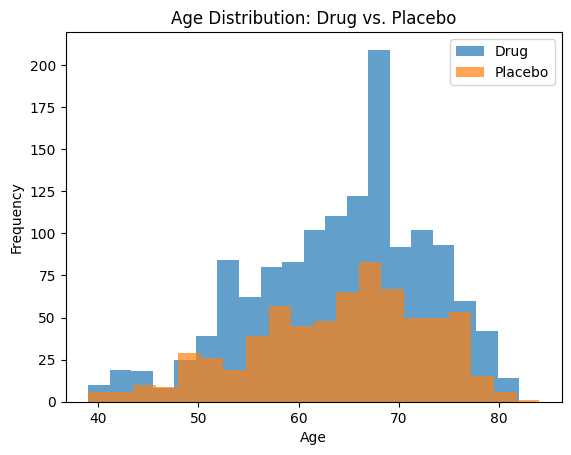

In [16]:
## Check for normality: Is the age normally distributed?

import matplotlib.pyplot as plt

# Split data by group
age_drug = df_grouped[df_grouped['trx'] == 'Drug']['age']
age_placebo = df_grouped[df_grouped['trx'] == 'Placebo']['age']

# Plot histograms
plt.hist(age_drug, bins=20, alpha=0.7, label='Drug')
plt.hist(age_placebo, bins=20, alpha=0.7, label='Placebo')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution: Drug vs. Placebo")
plt.legend()
plt.show()


### - the placebo appears normal while the drug is jagged

#### Test for normality Using the Shapiro-Wilk Test

In [17]:
from scipy.stats import shapiro

# Test normality for Drug group
shapiro_drug = shapiro(age_drug)
print("Drug group: W =", shapiro_drug.statistic, "P-value =", shapiro_drug.pvalue)

# Test normality for Placebo group
shapiro_placebo = shapiro(age_placebo)
print("Placebo group: W =", shapiro_placebo.statistic, "P-value =", shapiro_placebo.pvalue)


Drug group: W = 0.9766532973364539 P-value = 3.964972624121207e-14
Placebo group: W = 0.9752768986050059 P-value = 2.4114208159527106e-09


### Interpretation:
Both p-values are much less than 0.05

This means:

➤ Neither group has a normal distribution of age

➤ The age data in both groups is not bell-shaped

### - use the **Mann-Whitney U Test**, which does not assume normality and compares the distributions of age values.

## **Mann-Whitney U** **Test**

In [18]:
from scipy.stats import mannwhitneyu

# Run the test
stat, age_group_effects_p_value = mannwhitneyu(age_drug, age_placebo, alternative='two-sided')

# Print the result
print("Mann-Whitney U Statistic:", stat)
print("P-value:", age_group_effects_p_value)


Mann-Whitney U Statistic: 475848.0
P-value: 0.6397727966612736


#### Points to note:
##### - stat: the U-statistic → tells how ranks differ between the two groups (you usually don't interpret this directly)
-age_group_effects_p_value: the p-value → the key result

## Interpretation:
### -Mann-Whitney U Statistic: 475848.0
### -P-value: 0.6397727966612736

##### -P-value = 0.6398, which is much greater than 0.05.

##### This means:
##### The age distributions in the Drug and Placebo groups are not significantly different.

## Conclusion:
##### -Age is not a confounder in the clinical trial. The Drug and Placebo groups are fairly balanced in age, so age is not likely to be influencing the differences in side effects.